# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from netlib import *
import os
import shutil

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

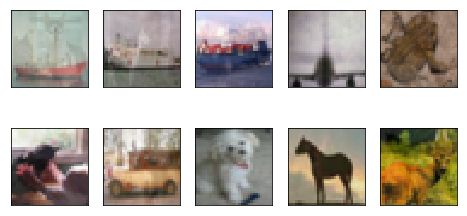

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.          0.          0.          0.18689434  0.          0.          0.
    0.          0.81310564  0.        ]]

 [[ 0.          0.          0.          0.          0.18689434  0.          0.
    0.          0.81310564  0.        ]]

 [[ 0.          0.18689434  0.          0.          0.          0.          0.
    0.          0.81310564  0.        ]]

 [[ 0.81310564  0.          0.          0.          0.18689434  0.          0.
    0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.          0.18689434
    0.81310564  0.          0.          0.        ]]

 [[ 0.          0.          0.          0.81310564  0.          0.
    0.18689434  0.          0.          0.        ]]

 [[ 0.          0.81310564  0.          0.          0.18689434  0.          0.
    0.          0.          0.        ]]

 [[

In [6]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [7]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [21]:
from cifar10_utils import show_images
%matplotlib inline

def SGD(data, lr):
    data[:] = data - data.grad * lr
    
def show_data(data, clip=True):
    mean=np.array([0.4914, 0.4822, 0.4465])
    std=np.array([0.2023, 0.1994, 0.2010])
    images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    show_images(images)
    
def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=True, combine_batch=False):
    for iters in range(1, max_iters+1):
        with autograd.record():
            data.attach_grad()
            output = net(data.as_in_context(ctx))
            loss = -loss_f(output, label.as_in_context(ctx))
        loss.backward()
        
        if iter_log and iters % 50 == 0:
            show_data(data, clip)
            print data[0, 0, :2, :10]
            print data.grad[0, 0, :2, :10]
        if iter_log and iters % 5 == 0:
            print 'iter:', iters, 'loss:', nd.mean(loss).asscalar()
        
        SGD(data, lr)
    return data

## 3.2 view result

In [22]:
net = ResNet(10)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
for data, label in train_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break

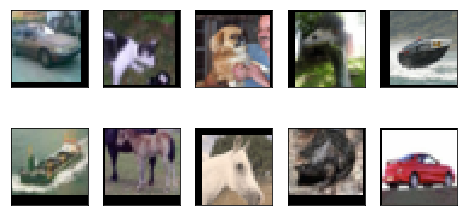

iter: 5 loss: -0.919129
iter: 10 loss: -5.93718
iter: 15 loss: -18.0934
iter: 20 loss: -23.9718
iter: 25 loss: -26.2919
iter: 30 loss: -27.9747
iter: 35 loss: -28.8903
iter: 40 loss: -29.6111
iter: 45 loss: -30.2203


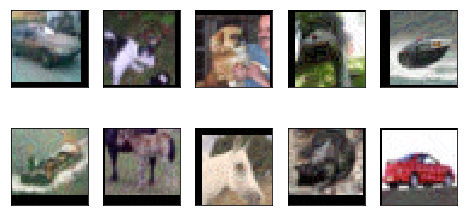


[[ 1.0395118   1.59808159  1.57878518  1.67939901  1.55738461  1.49466276
   1.17201972  1.18370032  1.1029613   1.04162097]
 [ 1.53976846  1.38116157  1.49177897  1.40779102  1.36130702  0.71075374
   0.68673795  0.56346017  0.50520307  0.33980101]]
<NDArray 2x10 @gpu(0)>

[[ 0.00272366 -0.01202599 -0.00063458 -0.02437401  0.05392938 -0.02218094
   0.02292476  0.00682752  0.00635326  0.01173221]
 [-0.01569999  0.00581998  0.00489836  0.02741691 -0.00991861  0.04216165
  -0.03011114 -0.01270352  0.01562051  0.00022257]]
<NDArray 2x10 @gpu(0)>
iter: 50 loss: -30.7664
iter: 55 loss: -31.069
iter: 60 loss: -31.3907
iter: 65 loss: -31.688
iter: 70 loss: -31.9304
iter: 75 loss: -32.1369
iter: 80 loss: -32.3522
iter: 85 loss: -32.5297
iter: 90 loss: -32.7319
iter: 95 loss: -32.8497


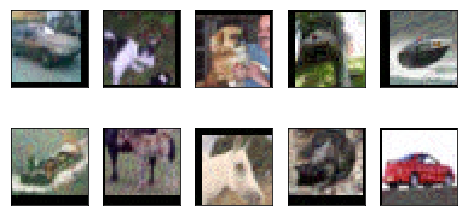


[[ 1.09848177  1.58430707  1.5895251   1.68661571  1.53188109  1.51253498
   1.09437048  1.1512171   1.08241558  1.00046003]
 [ 1.56982756  1.39722633  1.46802592  1.34945309  1.33252215  0.71587306
   0.82985437  0.63051939  0.51986891  0.4551051 ]]
<NDArray 2x10 @gpu(0)>

[[ -3.56941437e-03   1.12662800e-02  -1.37003595e-02  -9.69697721e-05
   -1.05658099e-02   8.30635056e-03  -4.57734801e-03   1.78031940e-02
   -1.24026742e-03   1.47219589e-02]
 [ -2.39958800e-03  -2.06433795e-02   2.68224720e-02  -2.12019421e-02
    4.51219007e-02  -1.61984209e-02  -1.85393374e-02  -1.85584351e-02
   -7.22179562e-03  -1.04619497e-02]]
<NDArray 2x10 @gpu(0)>
iter: 100 loss: -32.9947


In [23]:
show_data(data, False)
backgrad_data = generate_backgrad_data(net, data.copy(), label, max_iters=100, lr=0.1, iter_log=True, clip=False)

## 3.3 other implement

In [ ]:
data_dict = gluon.ParameterDict()
data_param = gluon.Parameter('data')
data_param.set_data(data)
data_dict.update({'data': data_param})
data_dict['data'].set_data(data)
trainer = gluon.Trainer(data_dict, 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
with autograd.record():
    output = net(data.as_in_context(ctx))
    loss = -loss_f(output, label.as_in_context(ctx))
print data_dict['data'].data()
loss.backward()
#SGD(data, 0.1)
import mxnet.optimizer as opt
optimizer = opt.create('sgd', **{'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})#, param_dict=param_dict)
updater = opt.get_updater(optimizer)9

# 4. define train function

In [11]:
"""
train
"""
import datetime
import utils
import sys
from random import random

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2, back_grad_args=None):
    
    def train_batch(data, label, i, use_backgrad):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        # generate backgrad data
        if use_backgrad:
            args = back_grad_args
            args['prob'] = args.get('prob', 1)      # prob to use back grad data argument to prove origin data is used.
            if random() <= args['prob']:
                args['max_iters'], args['lr'] = args.get('max_iters', 60), args.get('lr', 0.1)
                data = generate_backgrad_data(args['net'], data, label, args['max_iters'], args['lr'], iter_log=False)
                if args.has_key('show_iters') and i % args['show_iters'] == 0:
                    show_data(data)
                
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
        if not use_mixup:
            _acc = utils.accuracy(output, label)
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        
        # back grad
        use_backgrad = False
        if back_grad_args is not None:
            args = back_grad_args
            if args.has_key('take_turn'):
                args['take_turn'] = not args['take_turn'] # only odd epoch(start 0) will use back grad

            if (not args.has_key('take_turn')) or args['take_turn'] == True:
                print "# back grad turn." 
                use_backgrad = True
        
        # mixup
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc = train_batch(data, label, i, use_backgrad)
                train_loss += _loss
                train_acc += _acc
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _ = train_batch(data, label, i, use_backgrad)
                train_loss += _loss
                i += 1
        
        # log info
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP

## 5.1 baseline: general lr policy train my resnet18

In [9]:
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_200e")

epoch 0, loss 1.75249, train_acc 0.3416, valid_acc 0.4678, Time 00:00:31,lr 0.1
epoch 1, loss 1.23604, train_acc 0.5568, valid_acc 0.5724, Time 00:00:32,lr 0.1
epoch 2, loss 0.93259, train_acc 0.6715, valid_acc 0.7011, Time 00:00:32,lr 0.1
epoch 3, loss 0.78639, train_acc 0.7277, valid_acc 0.6987, Time 00:00:30,lr 0.1
epoch 4, loss 0.68671, train_acc 0.7642, valid_acc 0.7434, Time 00:00:30,lr 0.1
epoch 5, loss 0.62936, train_acc 0.7856, valid_acc 0.7396, Time 00:00:30,lr 0.1
epoch 6, loss 0.59543, train_acc 0.7951, valid_acc 0.7949, Time 00:00:30,lr 0.1
epoch 7, loss 0.56563, train_acc 0.8073, valid_acc 0.7511, Time 00:00:31,lr 0.1
epoch 8, loss 0.54190, train_acc 0.8125, valid_acc 0.7714, Time 00:00:30,lr 0.1
epoch 9, loss 0.51894, train_acc 0.8220, valid_acc 0.8141, Time 00:00:30,lr 0.1
epoch 10, loss 0.50352, train_acc 0.8259, valid_acc 0.7803, Time 00:00:30,lr 0.1
epoch 11, loss 0.49073, train_acc 0.8327, valid_acc 0.8127, Time 00:00:31,lr 0.1
epoch 12, loss 0.47917, train_acc 0.83

epoch 101, loss 0.05123, train_acc 0.9828, valid_acc 0.9259, Time 00:00:30,lr 0.01
epoch 102, loss 0.04977, train_acc 0.9830, valid_acc 0.9254, Time 00:00:30,lr 0.01
epoch 103, loss 0.05176, train_acc 0.9827, valid_acc 0.9254, Time 00:00:30,lr 0.01
epoch 104, loss 0.05073, train_acc 0.9826, valid_acc 0.9237, Time 00:00:30,lr 0.01
epoch 105, loss 0.05045, train_acc 0.9829, valid_acc 0.9311, Time 00:00:30,lr 0.01
epoch 106, loss 0.04769, train_acc 0.9841, valid_acc 0.9267, Time 00:00:35,lr 0.01
epoch 107, loss 0.05069, train_acc 0.9823, valid_acc 0.9261, Time 00:00:34,lr 0.01
epoch 108, loss 0.04908, train_acc 0.9833, valid_acc 0.9308, Time 00:00:31,lr 0.01
epoch 109, loss 0.05262, train_acc 0.9825, valid_acc 0.9267, Time 00:00:30,lr 0.01
epoch 110, loss 0.05038, train_acc 0.9829, valid_acc 0.9237, Time 00:00:30,lr 0.01
epoch 111, loss 0.04573, train_acc 0.9848, valid_acc 0.9262, Time 00:00:30,lr 0.01
epoch 112, loss 0.05370, train_acc 0.9811, valid_acc 0.9257, Time 00:00:30,lr 0.01
epoc

## 5.2 baseline: general lr policy train my resnet18

In [12]:
def get_net(ctx):
    num_outputs = 10
    net = ResNet(num_outputs)
    net.collect_params().initialize(init=init.Xavier(), ctx=ctx, force_reinit=True)
    return net  

In [13]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_80e")

epoch 0, loss 1.77454, train_acc 0.3359, valid_acc 0.4593, Time 00:00:28,lr 0.1
epoch 1, loss 1.22612, train_acc 0.5583, valid_acc 0.6111, Time 00:00:30,lr 0.1
epoch 2, loss 0.92693, train_acc 0.6722, valid_acc 0.7267, Time 00:00:30,lr 0.1
epoch 3, loss 0.76931, train_acc 0.7306, valid_acc 0.7550, Time 00:00:30,lr 0.1
epoch 4, loss 0.68570, train_acc 0.7619, valid_acc 0.7462, Time 00:00:30,lr 0.1
epoch 5, loss 0.63370, train_acc 0.7816, valid_acc 0.7396, Time 00:00:30,lr 0.1
epoch 6, loss 0.59709, train_acc 0.7953, valid_acc 0.7863, Time 00:00:30,lr 0.1
epoch 7, loss 0.56755, train_acc 0.8042, valid_acc 0.8034, Time 00:00:30,lr 0.1
epoch 8, loss 0.54272, train_acc 0.8134, valid_acc 0.8032, Time 00:00:30,lr 0.1
epoch 9, loss 0.51638, train_acc 0.8239, valid_acc 0.7898, Time 00:00:31,lr 0.1
epoch 10, loss 0.50288, train_acc 0.8261, valid_acc 0.8228, Time 00:00:31,lr 0.1
epoch 11, loss 0.48764, train_acc 0.8325, valid_acc 0.7678, Time 00:00:30,lr 0.1
epoch 12, loss 0.47348, train_acc 0.83

In [13]:
net1 = ResNet(10)
net1.initialize(ctx=ctx)
net1.hybridize()
net1.load_params("../../models/resnet18_me_80e", ctx=ctx)

net2 = ResNet(10)
net2.initialize(ctx=ctx)
net2.hybridize()
net2.load_params("../../models/resnet18_me_80e", ctx=ctx)

num_epochs = 80
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net2, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, back_grad_args={'net': net1, 'max_iters': 10, 'lr': 0.5, 'take_turn': True})#, 'show_iters': 1000})
net2.save_params("../../models/resnet18_me_80e_backgrad_taketurn_80e")

epoch 0, loss 0.33917, train_acc 0.8837, valid_acc 0.8295, Time 00:00:30,lr 0.1
# back grad turn.
epoch 1, loss 0.61268, train_acc 0.7929, valid_acc 0.5011, Time 00:04:38,lr 0.1
epoch 2, loss 0.42109, train_acc 0.8559, valid_acc 0.8313, Time 00:00:31,lr 0.1
# back grad turn.
epoch 3, loss 0.37783, train_acc 0.8730, valid_acc 0.6284, Time 00:04:45,lr 0.1
epoch 4, loss 0.41799, train_acc 0.8580, valid_acc 0.8328, Time 00:00:31,lr 0.1
# back grad turn.
epoch 5, loss 0.31489, train_acc 0.8948, valid_acc 0.6560, Time 00:04:43,lr 0.1
epoch 6, loss 0.41990, train_acc 0.8561, valid_acc 0.8566, Time 00:00:31,lr 0.1
# back grad turn.
epoch 7, loss 0.30543, train_acc 0.8986, valid_acc 0.5993, Time 00:04:44,lr 0.1
epoch 8, loss 0.42578, train_acc 0.8554, valid_acc 0.8545, Time 00:00:30,lr 0.1
# back grad turn.
epoch 9, loss 0.28968, train_acc 0.9046, valid_acc 0.5142, Time 00:04:41,lr 0.1
epoch 10, loss 0.42118, train_acc 0.8554, valid_acc 0.8623, Time 00:00:30,lr 0.1
# back grad turn.
epoch 11, l

In [13]:
net1 = ResNet(10)
net1.initialize(ctx=ctx)
net1.hybridize()
net1.load_params("../../models/resnet18_me_80e", ctx=ctx)

net2 = ResNet(10)
net2.initialize(ctx=ctx)
net2.hybridize()
net2.load_params("../../models/resnet18_me_80e", ctx=ctx)

num_epochs = 80
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net2, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, back_grad_args={'net': net1, 'max_iters': 10, 'lr': 0.5})#, 'show_iters': 1000})
net2.save_params("../../models/resnet18_me_80e_backgrad_80e")

# back grad turn.
epoch 0, loss 0.94735, train_acc 0.6747, valid_acc 0.7750, Time 00:04:32,lr 0.1
# back grad turn.
epoch 1, loss 0.31330, train_acc 0.8934, valid_acc 0.7914, Time 00:04:43,lr 0.1
# back grad turn.


Process Process-9:
Process Process-10:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 120, in worker_loop
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 120, in worker_loop
    data_queue.put((idx, batch))
    data_queue.put((idx, batch))
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 101, in put
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 101, in put
    if not self._sem.acquire(block, timeout

KeyboardInterrupt: 

In [ ]:
net1 = ResNet(10)
net1.initialize(ctx=ctx)
net1.hybridize()
net1.load_params("../../models/resnet18_me_80e", ctx=ctx)

net2 = ResNet(10)
net2.initialize(ctx=ctx)
net2.hybridize()
net2.load_params("../../models/resnet18_me_80e", ctx=ctx)

num_epochs = 80
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net2, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, back_grad_args={'net': net1, 'max_iters': 10, 'lr': 0.5, 'prob': 0.5})#, 'show_iters': 1000})
net2.save_params("../../models/resnet18_me_80e_backgrad_prob_80e")

# back grad turn.
epoch 0, loss 0.68236, train_acc 0.7756, valid_acc 0.8305, Time 00:02:33,lr 0.1
# back grad turn.
epoch 1, loss 0.41727, train_acc 0.8557, valid_acc 0.7920, Time 00:02:36,lr 0.1
# back grad turn.
epoch 2, loss 0.39819, train_acc 0.8667, valid_acc 0.8122, Time 00:02:34,lr 0.1
# back grad turn.
epoch 3, loss 0.38315, train_acc 0.8684, valid_acc 0.8128, Time 00:02:34,lr 0.1
# back grad turn.
epoch 4, loss 0.38068, train_acc 0.8709, valid_acc 0.8430, Time 00:02:35,lr 0.1
# back grad turn.
epoch 5, loss 0.37842, train_acc 0.8715, valid_acc 0.7407, Time 00:02:38,lr 0.1
# back grad turn.
epoch 6, loss 0.37304, train_acc 0.8726, valid_acc 0.8007, Time 00:02:32,lr 0.1
# back grad turn.
epoch 7, loss 0.37603, train_acc 0.8710, valid_acc 0.8216, Time 00:02:35,lr 0.1
# back grad turn.
epoch 8, loss 0.36470, train_acc 0.8754, valid_acc 0.7756, Time 00:02:39,lr 0.1
# back grad turn.
epoch 9, loss 0.35957, train_acc 0.8786, valid_acc 0.8319, Time 00:02:42,lr 0.1
# back grad turn.
ep

In [16]:
net1 = ResNet(10)
net1.initialize(ctx=ctx)
net1.hybridize()
net1.load_params("../../models/resnet18_me_80e", ctx=ctx)

net2 = ResNet(10)
net2.initialize(ctx=ctx)
net2.hybridize()
net2.load_params("../../models/resnet18_me_80e", ctx=ctx)

num_epochs = 20
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net2, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, back_grad_args={'net': net1, 'max_iters': 10, 'lr': 0.5, 'prob': 0.5})#, 'show_iters': 1000})
net2.save_params("../../models/resnet18_me_200e_200iter")

Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 59, in send
    self.send_bytes(buf.getvalue())
IOError: [Errno 32] Broken pipe


epoch 0, loss 0.33815, train_acc 0.8833, valid_acc 0.8433, Time 00:00:31,lr 0.1
# use back grad.
epoch 1, loss 0.61523, train_acc 0.7929, valid_acc 0.7767, Time 00:04:48,lr 0.1
# use back grad.


Process Process-651:
Process Process-652:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 120, in worker_loop
    data_queue.put((idx, batch))
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 101, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 120, in worker_loop
    data_queue.put((idx, batch))
  File "/usr/lib/python2.7/multiprocessing/queue

KeyboardInterrupt: 